In [12]:
# default_exp data

In [13]:
#export
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.basics import *
from dataclasses import field,asdict
from typing import List,Any
from collections import deque
import gym

if IN_NOTEBOOK:
    from IPython import display
    import PIL.Image

In [14]:
# hide
from nbdev.showdoc import *
from nbdev.imports import *
from nbdev.export2html import *
if not os.environ.get("IN_TEST", None):
    assert IN_NOTEBOOK
    assert not IN_COLAB
    assert IN_IPYTHON

# ExperienceSourceDatasets

> Iterable datasets for returning environment outputs.

## EnvLists

> Iterable lists for returning environment outputs.

In [15]:
# export
@delegates(TfmdLists.__init__)
class EnvLists(TfmdLists):
    def __init__(self,items,tfms,**kwargs):
        self.is_set=False
        super().__init__(items,tfms,**kwargs)
    
    def __len__(self):
        if (len(self.items)!=0 and not issubclass(type(self.items[0]),gym.Env)) or not self.is_set: return len(self.items) 
        else:                                                                                       return self.items[0].spec.max_episode_steps

    def _get(self,i): return i if self.is_set else super()._get(i) 
        
    def setup(self,train_setup=True):
        super().setup(train_setup)
        for f in self.fs:
            if hasattr(f,'reset'):f.reset()
        self.is_set=True

### EnvMakeTfm

> Make environments into their openai gym versions.

In [518]:
# export
class EnvMakeTfm(Transform):    
    def setup(self,items=None,train_setup=False):
        for i,o in enumerate(items):
            print(o)
            items[i]=gym.make(o)
        return super().setup(items,train_setup)

Check that the correct environment was created.

In [17]:
tl=EnvLists(['CartPole-v1' for _ in range(5)],tfms=[EnvMakeTfm])
test_eq(len(tl),500)
for o in tl:test_stdout(lambda:print(tl.items[o%5]),'<TimeLimit<CartPoleEnv<CartPole-v1>>>')

### EnvResetTfms

> Handles environment resetting.

In [289]:
# export
@dataclass
class DoneStateEnv:d:bool;s:np.array;env:object
DoneStateEnv.__repr__=lambda self:str((self.d,self.s,self.env))

@dataclass
class EnvResetTfm(Transform):
    env_idx:int=0;seed:Optional[int]=None;s:Optional[np.ndarray]=None;d:bool=False;was_setup:bool=False
    callback:DoneStateEnv=field(default_factory=lambda:DoneStateEnv(True,None,None))
    items:List[gym.Env]=field(default_factory=list)

    def setup(self,items=None,train_setup=False):
        for o in items:self.items.append(o)
        self._env_idx=len(items)
        return self 
    
    def reset(self):
        self._env_idx=0
        if self.seed is not None:[o.seed(self.seed) for o in self.items]
        self.s=[_o.reset() for _o in self.items]
        self.d=[False for _ in self.items]
        self.callback=DoneStateEnv(d=self.d[self._env_idx],s=self.s[self._env_idx],env=self.items[self._env_idx])
    
    def encodes(self,o:int):        
        if self.callback.d:
#             print('was done lol')
            self._env_idx+=1
            if self._env_idx>=len(self.items):self.reset()
            self.callback=DoneStateEnv(d=self.d[self._env_idx],s=self.s[self._env_idx],env=self.items[self._env_idx])
#             print(self.callback.s)
        return self.callback

Check that the `_env_idx` is incremented per iter. The intention is that a generating `Transform` uses the value to generate many elements.

In [290]:
n_envs=5
tl=EnvLists(['CartPole-v1' for _ in range(n_envs)],tfms=[EnvMakeTfm,EnvResetTfm(seed=0)])

next_inc=0
for ii in range(50):
    for i,o in enumerate(tl):
        if ii==0:test_eq(str(o.s),str(np.array([-0.04456399,  0.04653909,  0.01326909, -0.02099827])))
        test_eq(tl.tfms[1]._env_idx,next_inc)
        test_eq(tl.tfms[1].items.index(o.env),next_inc)
        test_eq(str(o),str((False,np.array([-0.04456399,  0.04653909,  0.01326909, -0.02099827]),tl.items[0])))
    o.d=True
    next_inc=next_inc+1 if next_inc<n_envs-1 else 0
# for o in tl:test_eq(str(o),str((False,np.array([-0.04456399,  0.04653909,  0.01326909, -0.02099827]),tl.items[0])))

### EnvGenUnwrapTfm
> Unwraps generators into 1d lists.

In [291]:
# export
@dataclass
class EnvGenUnwrapTfm(Transform):
    step:int=0
    
    def encodes(self,o:Generator): 
        result= tuple([xx for x in o for xx in x]) 
        self.step+=1
        return result

### EnvStepTfm

> Handles stepping through environments. 

In [292]:
%matplotlib inline

In [293]:
# export    
def env_display(env:gym.Env):
    img=env.render('rgb_array')
    try:display.clear_output(wait=True)
    except AttributeError:pass
    new_im=PIL.Image.fromarray(img)
    display.display(new_im)

In [294]:
# export
@dataclass
class Experience:d:bool;s:np.ndarray;sp:np.ndarray;r:float;a:Any

@dataclass
class EnvStepTfm(Transform):
    agent:Optional[object]=None;constant_action:Optional[int]=None;n_steps:int=1;steps_delta:int=1;step:int=-1
    _reset_step:bool=False;history:deque=None;display:bool=False;enc_set:bool=False
    
    def __post_init__(self):     self.history=deque(maxlen=self.n_steps)
    def bump_step_count(self,d): self.step=0 if d else self.step+1
    def reset(self):             self.step=0; self.history.clear()
        
    def encodes(self,o:DoneStateEnv):
        while True:
            if self.agent is None: a=ifnone(self.constant_action,o.env.action_space.sample()) 
            else:                  a=self.agent(o.s)
                
            sp,r,o.d,_=o.env.step(a)
            if self.display:env_display(o.env)
            self.history.append(Experience(d=o.d,s=o.s.copy(),sp=sp.copy(),r=r,a=a))
            o.s=sp.copy()
            self.bump_step_count(o.d)
            if o.d:
                while len(self.history)>1: # We allow the a single element left to be yielded by the broken while
                    yield tuple(self.history)
                    self.history.popleft()
                break
#             print(len(self.history),((self.step-1)%self.steps_delta),self.step)
            if len(self.history)==self.n_steps and ((self.step-1)%self.steps_delta)==0 and not o.d or \
                 (len(self.history)==self.step and len(self.history)==self.n_steps and not o.d):break
            
        history=tuple(copy(self.history))
        if o.d:self.history.clear();self.reset()
        yield tuple(history)
        return None

In [24]:
def validate_env(env_name,a,n_steps,steps_delta,n_envs,env_steps,dones,max_iter=800,n_episodes_break=-1,
                 initial_s=str(np.array([-0.58912799 , 0.        ])),
                 final_s=str(np.array([-0.71048047,  0.00427297]))):
    tl=EnvLists([env_name for _ in range(n_envs)],tfms=[EnvMakeTfm,EnvResetTfm(seed=0),
                                                        EnvStepTfm(constant_action=a,n_steps=n_steps,steps_delta=steps_delta,display=False),EnvGenUnwrapTfm])
    print('Starting loop')
    count=0
    for k in range(n_envs):
        print('\n\n')
        for i,o in enumerate(tl):
#             print(count,o)
            count+=1
#             print(o,i)
            if i==0:test_eq(str(o[0].s),initial_s)
            for exp in o:test_eq(exp.a,a)
            
            if any(_.d for _ in o):break
        if any(_.d for _ in o):
            test_eq(str(o[-1].sp),final_s)
            dones+=1
            if count>round((env_steps*n_envs)/steps_delta)-10:break
                
    
#     test_eq(count-(steps_delta!=1)*n_envs+((n_steps-1)*n_envs),round((env_steps*n_envs)/steps_delta))
    # If both are changed, the env will loop extra times at the start
    extra_steps_on_start=0 if n_steps==1 or steps_delta==1 else min((steps_delta,n_steps))-1
    
    
    test_eq(count-(steps_delta!=1)*n_envs+((n_steps-1)*n_envs),round((env_steps*n_envs)/steps_delta)+extra_steps_on_start)
    test_eq(n_envs,dones)

Check that `MountainCar-v0` with `steps_delta=2` has single episode lengths cut in half. Verify that each episode keeps its `done` signal.

In [25]:
validate_env(
    env_name='MountainCar-v0',
    a=0,
    n_steps=1,
    steps_delta=2,
    n_envs=1,
    env_steps=200,
    dones=0,
    n_episodes_break=1
)

Starting loop





Check that `MountainCar-v0` at defaults, runs the full 200 iterations.
Check that all actions are `a`

In [26]:
validate_env(
    env_name='MountainCar-v0',
    a=0,
    n_steps=1,
    steps_delta=1,
    n_envs=1,
    env_steps=200,
    dones=0
)

Starting loop





Check that `MountainCar-v0` at defaults, with 2 envs, fully resets between episodes, and that the starting and ending states are always output.

In [27]:
validate_env(
    env_name='MountainCar-v0',
    a=0,
    n_steps=1,
    steps_delta=1,
    n_envs=2,
    env_steps=200,
    dones=0
)

Starting loop








Check that `MountainCar-v0` with `n_steps=2` has single episode iterations is cut in half. Verify that each episode keeps its `done` signal.

In [28]:
validate_env(
    env_name='MountainCar-v0',
    a=0,
    n_steps=2,
    steps_delta=1,
    n_envs=1,
    env_steps=200,
    dones=0
)

Starting loop





Check that `CartPole-v1` iterates correctly also.

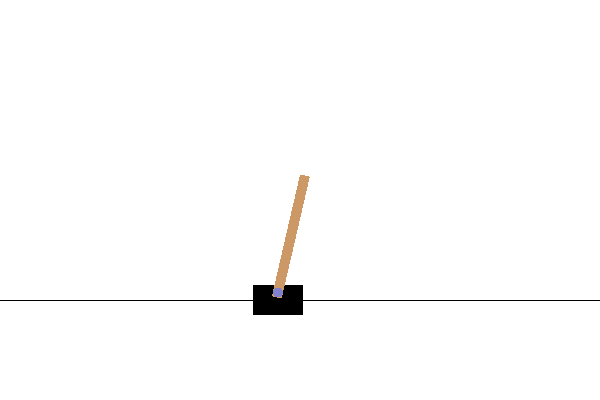

8


In [29]:
count=0
dones=0
env_steps=10
steps_delta=1
n_steps=2
n_envs=1

tl=EnvLists(['CartPole-v0' for _ in range(n_envs)],tfms=[EnvMakeTfm,EnvResetTfm(seed=0),
                                                    EnvStepTfm(constant_action=0,n_steps=n_steps,steps_delta=steps_delta,display=True),EnvGenUnwrapTfm])
print('Starting loop')
for k in range(n_envs):
    print('\n\n')
    for i,o in enumerate(tl):
#             print(count,o)
        count+=1
#             print(o,i)
        if i==0:test_eq(str(o[0].s),'[-0.04456399  0.04653909  0.01326909 -0.02099827]')
        for exp in o:test_eq(exp.a,0)

        if any(_.d for _ in o):break
    if any(_.d for _ in o):
        test_eq(str(o[-1].sp),'[-0.17695373 -1.71499924  0.22743892  2.78917835]')
        dones+=1
        if count>round((env_steps*n_envs)/steps_delta)-10:break

print(count)

In [395]:
@dataclass
class ExperienceToDictTfm(Transform):
    def encodes(self,o:Experience):
        print('out pooting ',o)
        return asdict(o)

## DataBlock 

> Generates DataBlock appropriate for running OpenAI envs.

In [386]:
TfmdDL.create_item??

Signature: TfmdDL.create_item(self, s)
Docstring: <no docstring>
Source:        def create_item(self, s):  return next(self.it) if s is None else self.dataset[s]
File:      /opt/conda/envs/fastrl/lib/python3.7/site-packages/fastai/data/load.py
Type:      function


In [359]:
TestDataBlock.dataloaders??

Signature:
TestDataBlock.dataloaders(
    self,
    source,
    path='.',
    verbose=False,
    bs=64,
    shuffle=False,
    num_workers=None,
    do_setup=True,
    pin_memory=False,
    timeout=0,
    batch_size=None,
    drop_last=False,
    indexed=None,
    n=None,
    device=None,
    *,
    wif=None,
    before_iter=None,
    after_item=None,
    before_batch=None,
    after_batch=None,
    after_iter=None,
    create_batches=None,
    create_item=None,
    create_batch=None,
    retain=None,
    get_idxs=None,
    sample=None,
    shuffle_fn=None,
    do_batch=None,
)
Docstring: Create a `DataLoaders` object from `source`
Source:   
    def dataloaders(self, source, path='.', verbose=False, **kwargs):
        dsets = self.datasets(source)
#         print(dsets.splits)
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        return dsets.dataloaders(path=path, after_item=self.item_tfms, after_batch=self.batch_tfms,do_item=doer,**kwargs)
File:      /opt/projec

In [501]:
TfmdLists??

Init signature:
TfmdLists(
    items,
    tfms,
    use_list=None,
    do_setup=True,
    split_idx=None,
    train_setup=True,
    splits=None,
    types=None,
    verbose=False,
    dl_type=None,
)
Source:        
class TfmdLists(FilteredBase, L, GetAttr):
    "A `Pipeline` of `tfms` applied to a collection of `items`"
    _default='tfms'
    def __init__(self, items, tfms, use_list=None, do_setup=True, split_idx=None, train_setup=True,
                 splits=None, types=None, verbose=False, dl_type=None):
        super().__init__(items, use_list=use_list)
        if dl_type is not None: self._dl_type = dl_type
        self.splits = L([slice(None),[]] if splits is None else splits).map(mask2idxs)
        if isinstance(tfms,TfmdLists): tfms = tfms.tfms
        if isinstance(tfms,Pipeline): do_setup=False
        self.tfms = Pipeline(tfms, split_idx=split_idx)
        store_attr(self, 'types,split_idx')
        if do_setup:
            pv(f"Setting up {self.tfms}", verbose)
          

In [522]:
def doer(o):print('Itemm dorer',o)
def NoopSplitter(o):return [o]
    
class TestDataBlock(DataBlock):

    def datasets(self, source, verbose=False):
        self.source = source                     ; pv(f"Collecting items from {source}", verbose)
        items = (self.get_items or noop)(source) ; pv(f"Found {len(items)} items", verbose)
        splits = (self.splitter or RandomSplitter())(items)
        print('splits',splits,items)
        pv(f"{len(splits)} datasets of sizes {','.join([str(len(s)) for s in splits])}", verbose)
        return Datasets(None, tls=[EnvLists(items,tfms=self.item_tfms,splits=[[0]])], 
                        splits=splits, dl_type=self.dl_type, n_inp=self.n_inp, verbose=verbose)
    
    def dataloaders(self, source, path='.', verbose=False, **kwargs):
        pv(source,verbose)
        dsets = self.datasets(source)
        for dset in dests:
        print('Splits: ',dsets.splits[0])
        kwargs = {**self.dls_kwargs, **kwargs, 'verbose': verbose}
        return dsets.dataloaders(path=path,after_batch=self.batch_tfms,**kwargs)

In [516]:
ds=block.datasets(['MountainCar-v0' for _ in range(1)]);ds.tls[0].splits

splits [['MountainCar-v0']] ['MountainCar-v0']
EnvLists: ['MountainCar-v0']
tfms - (#0) []


(#1) [[0]]

In [523]:
block=TestDataBlock(splitter=NoopSplitter,item_tfms=[EnvMakeTfm,EnvResetTfm(seed=0),
                                                 EnvStepTfm(constant_action=0,n_steps=n_steps,steps_delta=steps_delta,display=False),
                                                 EnvGenUnwrapTfm,
                                                 ExperienceToDictTfm])
dls=DataLoaders.from_dblock(block,['MountainCar-v0' for _ in range(1)],bs=20,verbose=True,shuffle_train=False,num_workers=0)

['MountainCar-v0']
splits [['MountainCar-v0']] ['MountainCar-v0']
MountainCar-v0
Splits:  [0]
Setting up after_item: Pipeline: 
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: 


In [525]:
dls[0].do_batch([dls[0].do_item(0)])

out pooting  Experience(d=False, s=array([-0.58912799,  0.        ]), sp=array([-5.89639679e-01, -5.11690400e-04]), r=-1.0, a=0)
out pooting  Experience(d=False, s=array([-5.89639679e-01, -5.11690400e-04]), sp=array([-0.5906593 , -0.00101962]), r=-1.0, a=0)


(({'d': tensor([False]),
   's': tensor([[-0.5891,  0.0000]], dtype=torch.float64),
   'sp': tensor([[-5.8964e-01, -5.1169e-04]], dtype=torch.float64),
   'r': tensor([-1.], dtype=torch.float64),
   'a': tensor([0])},
  {'d': tensor([False]),
   's': tensor([[-5.8964e-01, -5.1169e-04]], dtype=torch.float64),
   'sp': tensor([[-0.5907, -0.0010]], dtype=torch.float64),
   'r': tensor([-1.], dtype=torch.float64),
   'a': tensor([0])}),)

In [537]:
dls[0].dataset.tls

(#1) [EnvLists: [0]
tfms - (#6) [EnvMakeTfm:
encodes: decodes: ,EnvResetTfm(env_idx=0, seed=0, s=[array([-0.58912799,  0.        ])], d=[False], was_setup=False, callback=(False, array([-0.61094068, -0.00416783]), <TimeLimit<MountainCarEnv<MountainCar-v0>>>), items=[<TimeLimit<MountainCarEnv<MountainCar-v0>>>]),EnvStepTfm(agent=None, constant_action=0, n_steps=2, steps_delta=1, step=9, _reset_step=False, history=deque([Experience(d=False, s=array([-0.60298766, -0.00337499]), sp=array([-0.60677285, -0.00378519]), r=-1.0, a=0), Experience(d=False, s=array([-0.60677285, -0.00378519]), sp=array([-0.61094068, -0.00416783]), r=-1.0, a=0)], maxlen=2), display=False, enc_set=False),EnvGenUnwrapTfm(step=8),ExperienceToDictTfm(),ToTensor:
encodes: decodes: ]]

In [526]:
len(dls[0].dataset.items)

1

In [534]:
len(dls[0])

1

In [543]:
dls[0].dataset.tls[0]

EnvLists: [0]
tfms - (#6) [EnvMakeTfm:
encodes: decodes: ,EnvResetTfm(env_idx=0, seed=0, s=[array([-0.58912799,  0.        ])], d=[False], was_setup=False, callback=(False, array([-0.61094068, -0.00416783]), <TimeLimit<MountainCarEnv<MountainCar-v0>>>), items=[<TimeLimit<MountainCarEnv<MountainCar-v0>>>]),EnvStepTfm(agent=None, constant_action=0, n_steps=2, steps_delta=1, step=9, _reset_step=False, history=deque([Experience(d=False, s=array([-0.60298766, -0.00337499]), sp=array([-0.60677285, -0.00378519]), r=-1.0, a=0), Experience(d=False, s=array([-0.60677285, -0.00378519]), sp=array([-0.61094068, -0.00416783]), r=-1.0, a=0)], maxlen=2), display=False, enc_set=False),EnvGenUnwrapTfm(step=8),ExperienceToDictTfm(),ToTensor:
encodes: decodes: ]

In [545]:
len(dls[0].dataset.tls[0])

1

In [532]:
for x in dls[0]:
    print(x)
    break

out pooting  Experience(d=False, s=array([-0.59961267, -0.00294017]), sp=array([-0.60298766, -0.00337499]), r=-1.0, a=0)
out pooting  Experience(d=False, s=array([-0.60298766, -0.00337499]), sp=array([-0.60677285, -0.00378519]), r=-1.0, a=0)
(({'d': tensor([False]), 's': tensor([[-0.5996, -0.0029]], dtype=torch.float64), 'sp': tensor([[-0.6030, -0.0034]], dtype=torch.float64), 'r': tensor([-1.], dtype=torch.float64), 'a': tensor([0])}, {'d': tensor([False]), 's': tensor([[-0.6030, -0.0034]], dtype=torch.float64), 'sp': tensor([[-0.6068, -0.0038]], dtype=torch.float64), 'r': tensor([-1.], dtype=torch.float64), 'a': tensor([0])}),)


## Export

In [31]:
# hide
from nbdev.export import *
notebook2script()
notebook2html(n_workers=0)

Converted 00_core.ipynb.
Converted 01_wrappers.ipynb.
Converted 02_callbacks.ipynb.
Converted 03_basic_agents.ipynb.
Converted 04_metrics.ipynb.
Converted 05_data.ipynb.
Converted 06_basic_train.ipynb.
Converted 12_a3c.a3c_data.ipynb.
Converted index.ipynb.
Converted notes.ipynb.


converting: /opt/project/fastrl/nbs/12_a3c.a3c_data.ipynb
An error occurred while executing the following cell:
------------------
from nbdev.showdoc import show_doc
from fastrl.a3c.a3c_data import *
------------------

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
<ipython-input-1-19dfa7b4de72> in <module>
      1 from nbdev.showdoc import show_doc
----> 2 from fastrl.a3c.a3c_data import *

/opt/project/fastrl/fastrl/a3c/a3c_data.py in <module>
      7 import torch.nn.utils as nn_utils
      8 from fastai.torch_core import *
----> 9 from fastai.callbacks import *
     10 from fastai.basic_train import *
     11 from fastai.callback import *

ModuleNotFoundError: No module named 'fastai.callbacks'
ModuleNotFoundError: No module named 'fastai.callbacks'

converting: /opt/project/fastrl/nbs/05_data.ipynb
An error occurred while executing the following cell:
------------------
show_do

Exception: Conversion failed on the following:
12_a3c.a3c_data.ipynb
05_data.ipynb